The code that follows will create a figure that illustrates the perceptual comparison (of various initial light patterns) between the predictions made by the TCAE model and the Ground Truth (GT) data at various points in time. Additionally, it will present a quantitative comparison of the corresponding microtubule network area between the predictions of the TCAE model and the GT data.

In [1]:
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
from TCAE import TConvAutoEncoder
from skimage.io import ImageCollection
import matplotlib.pyplot as plt
from image_processing_functions import *

In [2]:
experiment_name = "prediction_am_sim_002"
base_dir = os.path.join(os.getcwd(), experiment_name)
weights_dir = os.path.join(base_dir,'weights')
data_dir = os.path.join(os.getcwd(), 'sim_data_112x112/') 

training_set  = np.load('training_set.npy')
validation_set  = np.load('validation_set.npy')
training_set = [data_dir + 'pattern_' + str(pattern).zfill(5) + '/*' for pattern in training_set]
validation_set = [data_dir + 'pattern_' + str(pattern).zfill(5) + '/*' for pattern in validation_set]
np.random.seed(10)
np.random.shuffle(validation_set)

# Load TCAE model
tcae = TConvAutoEncoder(64)
tcae((np.zeros((1,112,112,1)),np.zeros((1,1))))
tcae.load_weights(weights_dir + f'/TCAE_epoch_{29}.h5')

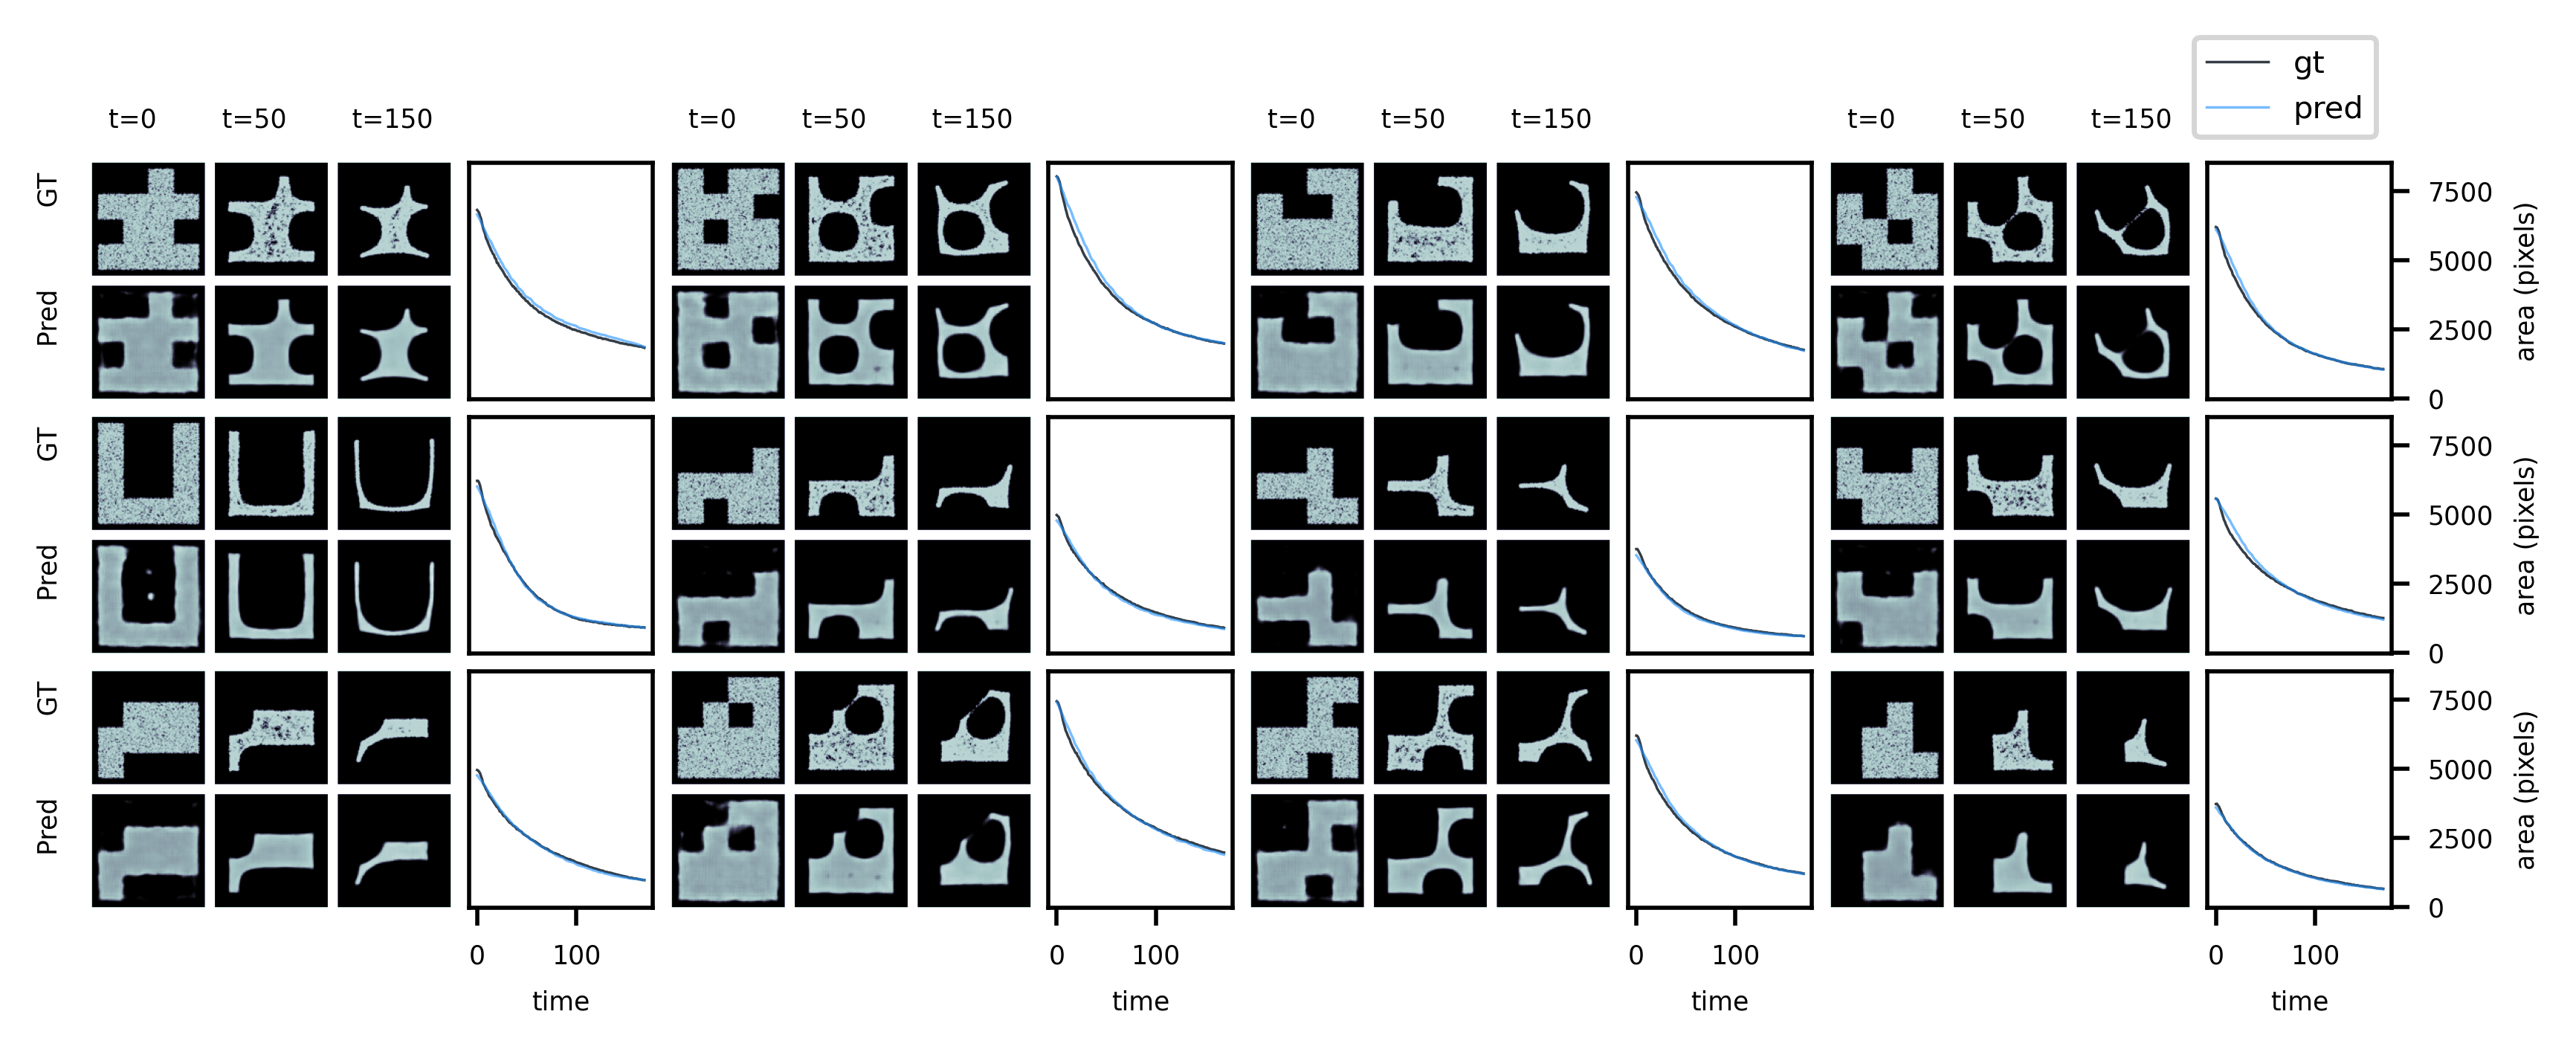

In [3]:
video_length = 170
times = [0,50,150] # Particular points in time at which we desire our prediction to be made
n_timesteps = len(times)
image_shape = (112,112) # shape of prediction image
image_pad = 5 # space between GT and prediction images in the figure
height = image_shape[0] + image_pad*2
width = image_shape[1] + image_pad*2
col_title_pad = 8 # add spaces between each "t=xi" for column title 
row_title_pad = 10 # add spaces between Pred and GT for row title

rows = 3 # number of rows in figure
cols = 8 # number of cols i figure
assert cols % 2 == 0, "# of cols must be even"

fig, ax = plt.subplots(rows, cols, gridspec_kw={'width_ratios': [2-i%2 for i in range(cols)]}, figsize = (8,2.7), dpi = 500)
row = 0
column = 0
for i in range((rows*cols)//2):
    
    # load GT data
    ic = ImageCollection(sorted(glob.glob(validation_set[i])), load_func=imread_convert)
    # Prepare Input for TCAE
    x = np.repeat(np.expand_dims(ic[0], (0)), video_length, axis=0)
    dt = np.expand_dims(np.arange(video_length, dtype='float32'), -1)
    # Get TCAE predictions
    y = tcae.predict((x,dt), verbose = 0)
    
    # Generate an empty image to be populated with predictions and GT data.
    im = np.zeros((height*2, width*n_timesteps)) # 112*2 since we need space for GT and pred images
    for j, t in enumerate(times):
        gt_padded = np.pad(ic[t][:,:,0], image_pad, constant_values = 1) # pad GT images to create a separation
        pred_padded = np.pad(y[t][:,:,0], image_pad, constant_values = 1)  # pad TCAE preds to create a separation
        im[0:height, width*j:width*(j+1)] += gt_padded # add GT data to empty image
        im[height:height*2, width*j:width*(j+1)] += pred_padded # add TCAE pred to empty image

    # quantify area of microtubule network for GT and and TCAE preds
    mask_pred = thresholding(y, method='otsu')
    mask_pred = remove_objects(mask_pred, min_size=100).astype('int')
    mask_gt = thresholding(np.array(ic), method='otsu')
    mask_gt = remove_objects(mask_gt, min_size=100).astype('int')
    area_pred = count_pixels(mask_pred)
    area_gt = count_pixels(mask_gt)
    
    # plot perceptive comparison 
    ax[row, column].imshow(im, cmap = 'bone')
    ax[row, column].axis('off')
    
    # plot microtubule network area comparison
    ax[row, column + 1].plot(range(video_length), area_gt,  c= '#343D46', linewidth = .5, alpha = 1, label = 'gt')
    ax[row, column + 1].plot(range(video_length), area_pred,  c= '#1E90FF', linewidth = .5, alpha = .6, label = 'pred')
    
    # first row only: include text indicating the specific moments in time at which the predictions were made
    if row == 0:
        ax[row, column].set_title((' '*col_title_pad).join(map(lambda t : "t="+str(t),times)), fontdict={'fontsize': 5})
    # first col only: include annotations specifying whether the images are predictions or GT data."
    if column == 0:
        ax[row, column].text(-50,100,"Pred" +" "*row_title_pad+"GT", size=5,verticalalignment='center', rotation=90)
    
    # Remove the x-axis ticks from all subplots except for the area plots in the last row
    if row != rows - 1:
        ax[row, column + 1].set_xticks([])
    else:
        ax[row, column + 1].tick_params(axis='x', labelsize=5)
        ax[row, column + 1].set_xlabel('time',  fontsize=5)
    
    # Remove the y-axis ticks from all subplots except for the area plots in the last col
    if column != cols - 2:
        ax[row, column + 1].set_yticks([])
    else:
        ax[row, column + 1].yaxis.tick_right()
        ax[row, column + 1].yaxis.set_label_position("right")
        ax[row, column + 1].tick_params(axis='y', labelsize=5)
        ax[row, column + 1].set_ylabel('area (pixels)',  fontsize=5)
    
    # aspect ratio of area plot
    ax[row, column + 1].set_aspect(.028)
    # The range of values for the y-axis of the area plot
    ax[row, column + 1].set_ylim((-10, 8500))
    
    # Include a legend in the top-right subplot
    if row == 0 and column == cols - 2:
        ax[row, column + 1].legend(bbox_to_anchor=(1.0, 1.6), prop={'size': 6})
    
    column += 2 # one col for images and one col for area plot
    
    # populate next row
    if (i + 1) % (cols//2) == 0:
        column = 0
        row += 1
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.02)